Primal problem:
$$\min c^T x \quad\text{subject to}\quad Ax=b, -x\leq 0.$$

Dual problem:
$$\max b^T y \quad\text{subject to}\quad A^Ty\leq c.$$

In [57]:
import numpy as np
from functions import newton_eq, plot_error_iter
import matplotlib.pyplot as plt
import cvxpy as cp

In [58]:
# m: number of constraints
# n: number of variables
m = 50
n = 200

A = np.random.randn(m, n)
x0 = np.random.random(n)
b = A.dot(x0)
z = np.random.randn(m)
s = 1*np.random.random(n)

# This is to make sure that the dual problem is feasible in interior since A.T @ z < c.
c = A.T.dot(z) + s

In [59]:
def cvx_solution(A, b, c)
    x = cp.Variable(n)
    obj = cp.Minimize(c@x)
    cons = [A@x == b, x >= 0]
    prob = cp.Problem(obj, cons)
    prob.solve(solver="MOSEK")
    return prob.value

Optimal value:  20.773942809023602


In [60]:
def get_res(x, lambda_, v, tinv, grad_f):
    r_dual = Dh(x).dot(lambda_) + A.T.dot(v) + grad_f(x)
    r_cent = -np.diag(lambda_)@h(x) - tinv
    r_pri = A.dot(x)-b
    return r_dual, r_cent, r_pri

def get_res_norm(x, lambda_, v, tinv, grad_f):
    r_dual, r_cent, r_pri = get_res(x, lambda_, v, tinv, grad_f)
    return np.linalg.norm(r_dual), np.linalg.norm(r_cent), np.linalg.norm(r_pri)

In [61]:
def primal_dual(grad_f, h, Dh, H_pd, x0, A, b, MAXITERS=100, TOL=1e-8,alpha = 0.01, beta = 0.8, RESTOL=1e-8):
    MAXITERS = MAXITERS
    TOL = TOL
    RESTOL = RESTOL
    mu = 10
    alpha = alpha
    beta = beta
    m, n = A.shape
    gaps = []
    resdls = []
    x = x0.copy()
    x_list = [x]
    h = h
    Dh = Dh
    H_pd = H_pd
    # Lagrange multiplier for inequality constraints
    lambda_ = -1 / (h(x))
    # Lagrange multiplier for equality constraints
    v = np.zeros(m)

    for iters in range(MAXITERS):
        # Surrogate duality gap
        ita = - h(x).dot(lambda_)
        gaps.append(ita)
        tinv = ita/(m*mu)

        r_dual, r_cent, r_pri = get_res(x, lambda_, v, tinv, grad_f)
        resdls.append(np.linalg.norm(np.hstack([r_dual, r_pri])))
        # stopping criterion
        if ita < TOL and resdls[-1] < RESTOL:
            break
        
        sol = -np.linalg.solve(
            np.block([[H_pd(x), Dh(x).T, A.T],
                    [-np.diag(lambda_)@Dh(x), -np.diag(h(x)), np.zeros((n, m))],
                    [A, np.zeros((m, m)), np.zeros((m, n))]]),
            np.hstack([r_dual, r_cent, r_pri])
        )
        dx = sol[:n]
        dlambda_ = sol[n:n+n]
        dv = sol[-m:]

        # backtracking line search
        # The maximum step such that the new lambda_ is positive, i.e., feasible.
        step = min(1, 0.99/np.max(-dlambda_/lambda_))
        while True:
            x_new = x + step*dx
            if np.all(h(x_new) < 0):
                break
            step *= beta

        new_x = x + step*dx
        new_lambda_ = lambda_ + step*dlambda_
        new_v = v + step*dv
        
        # Old residual norm
        old_norm = sum(get_res_norm(x, lambda_, v, tinv, grad_f))

        while sum(get_res_norm(new_x, new_lambda_, new_v, tinv, grad_f)) > (1- alpha * step) * old_norm:
            step *= beta
            new_x = x + step*dx
            new_lambda_ = lambda_ + step*dlambda_
            new_v = v + step*dv

        x = new_x
        lambda_ = new_lambda_
        v = new_v
        x_list.append(x)
    return x_list


In [62]:
grad_f = lambda x: c
h = lambda x: -x
Dh = lambda x: -np.eye(len(x))
H_pd = lambda x: np.zeros((len(x), len(x)))
x_list = primal_dual(grad_f, h, Dh, H_pd, x0.copy(), A, b, MAXITERS=100, TOL=1e-8,alpha = 0.01, beta = 0.8, RESTOL=1e-8)

## Solve by Log-barrier method
In this case, we have the problem
$$\min t c^T x-log(x)\quad \text{subject to}\quad  Ax=b$$

In [63]:
def log_barrier(x0, A, b, t, mu, TOL=1e-8, MAXITERS=100,  alpha=0.01, beta=0.8,print_iter=False):
    t = t
    x_inner = x0.copy()
    m, n = A.shape
    nabla_f = lambda x: np.diag(1/x**2)
    dom_f = lambda x: np.all(x>0)
    central_path = []
    while m/t > TOL:
        f = lambda x: t*c.dot(x) - np.sum(np.log(x))
        grad_f = lambda x: t*c - 1/x
        x_list = newton_eq(f, grad_f, nabla_f, x_inner, A, b, dom_f, MAXITERS=MAXITERS, TOL=TOL, alpha=alpha, beta=beta, print_iter=print_iter)
        x_inner = x_list[-1]
        t *= mu
        central_path.append(x_inner)
    return central_path

In [64]:
x_lb = log_barrier(x0, A, b, t=10, mu=2, TOL=1e-8, MAXITERS=1000,  alpha=0.01, beta=0.8, print_iter=False)

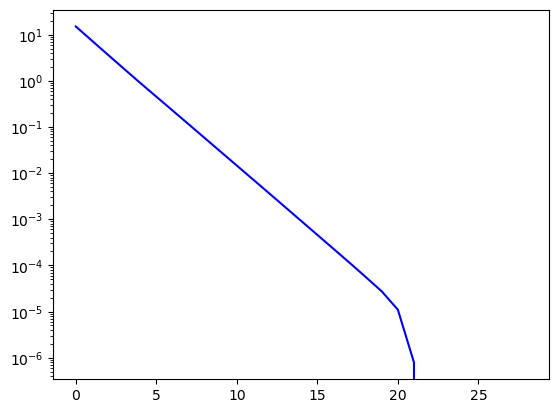

In [65]:
plot_error_iter(x_lb@c, prob.value, "Log Barrier Method")
# plt.ylim(1e-8, 1e2)
plt.yscale("log")

In [66]:
c@x_lb[-1]-prob.value, c@x_list[-1]- prob.value

(-0.001402078990508926, 4.255131358377184e-09)